## Module 07: Advection-Diffusion Equation: Assignment
### 1. Introduction and Background
This assignment starts off from the same notebook as the example notebook that we examined in class. But you will perform an additional set of simulations with this notebook. Specifically, at the conclusion of the example simulation, which keeps the holds the top of the soil column at saturation, you will run the model for an additional 2000 hours while holding the top of the soil column to a value of saturation of 30%. This is an approximation of a rainstorm that instantaneously stops.

The notebook that you submit for grading should contain the following plots:

1. A single plot of every 50th soil moisture profile during the first 2000 hours in blue (code already supplied) as well as a plot of every 50th soil moisture profile during the final 2000 hours in red.
2. A plot of the soil moisture at z = 50 cm and z = 2000 cm during the entire 4000 hour simulation. You may want to use plt.subplots() to create a subplot for each depth.

Also answer the following reflection questions:

* We know that framing the evolution of soil moisture as an advection-dispersion problem required a number of questionable assumptions. If a full Richards solving model is our best approximation of the underlying process, how might we assess under what conditions our model is a reasonable approximation? Specifically, describe a set of numerical experiments.
* In class we considered the case where we were using a flux boundary condition and the input flux rate was taken to be the minimum of the precipitation rate and saturated hydraulic conductivity of the soil. Under conditions where precipitation exceeds the saturated hydraulic conductivity, how might you model where the excess precipitation (precipitation minus saturated hydraulic conductivity) goes?

### 2. Model Setup and Prep

In [1]:
import numpy as np
import matplotlib.pyplot as plt

zmin = 0.0    # Elevation at the top of the soil column [cm]
zmax = 1000.0 # Elevation at the bottom of the soil column (by convention positive is into the Earth) [cm]

dz = 5.0 # Layer thickness for solving the advection-dispersion equation

t0 = 0.0 # Initial time of simulation [hr]
tf = 4000.0 # Final time of simulation [hr]

dt = 5.0 # Initial time step [hr]. NOTE: This may be changed below to satisfy the stability conditions of the QUICK method

Keff = 0.72e-4*3600 # Effective hydraulic conductivity in cm/hr
dhdtheta = 8 # Slope of the soil-water characteristics curve [cm]

Deff = Keff*dhdtheta


### 3. Change Delta t if Necessary

The QUICK method imposes two inequality conditions relating the Courant condition and diffusion number. Here we compute them with the initial values of dz, dt, Keff, and Deff set above. If the inequality conditions are not satisfied, we assume that the user would respond by reducing the time step first. In this case, we halve the initial time step, recompute the Courant condition and diffusion number, and repeat. This process repeats until the inequality conditions are met.

In [2]:
flag = 0 # This is used as a stopping criteria to break out of the while loop once the inequality conditions are met
count = 1 # Just a counter variable to see how many iterations we've performed (not used)

while (flag==0): 
    
    c = Keff*dt/dz # Calculate the Courant condition
    alpha = Deff*dt/(dz**2) # Calculate the diffusion number 
    
    if((c**2 <= 2*alpha) and ((alpha + c/4) <= 0.5)): # If inequality conditions are met
        flag = 1 # Set the flag = 1 and keep the current dt. 
    else: # If not
        dt = dt/2 # Halve the value of the time step and repeat
        
    count = count + 1 # Iterate counter
    
print('Final timestep = '+str(dt)) # Report the final time step


Final timestep = 5.0


### 4. Setup the Spatial and Temporal Domains

In [3]:
z = np.arange(dz/2, zmax, dz) # This is the vertical "mesh" or "grid"
Nz = z.size # Compute the total number of layers

In [4]:
t = np.arange(t0, tf, dt) # This is the time vector
Nt = t.size # Compute the total number of time steps

### 5. Define Initial Condition

Here we assume that the initial soil moisture is 20% everywhere in the soil profile initially.

In [5]:
theta0 = 0.2 * np.ones((Nz)) # Set initial soil moisture to 0.2 everywhere

### 6. Define Boundary Condition

Our boundary condition will consist of saturated conditions $\theta = 1$ at the top during the entire simulation.

In [6]:
thetatop = np.ones((Nt))
Nt_index = (np.absolute(t-2000)).argmin()
thetatop[Nt_index:] = 0.3*thetatop[Nt_index:]
print(Nt_index)


400


### 7. Create a Storage Container for Simulated Soil Moisture Profiles

In [7]:
theta = np.zeros((Nz,Nt))


### 8. Perform the Modeling Step

In [8]:
for i in np.arange(Nt): # Loop through time first
    
    if(i==0): # If the first time step, the initial soil moisture profile is the one set above
        theta_i = theta0
    else: # At subsequent time steps, the initial soil moisture is just the soil moisture simulated at the previous time
        theta_i = theta[:,i-1]
        
    # Create a dummy storage container for the simulated soil moisture at time step i+1
    theta_ip1 = np.zeros((Nz))
    
    # Loop through the layers
    for j in np.arange(Nz):
        
        if(j==0): # At the very top the soil moisture is equal to that at the boundary condition (thetatop)
            theta_ip1[j] = thetatop[i]
        elif(j==1): # At j=1, there is no j-2, so we assume the value at j-2 is the same as the value at j-1
            theta_ip1[j] = theta_i[j] - c*((1/8)*theta_i[j] - (7/8)*theta_i[j-1] + (3/8)*theta_i[j] 
                + (3/8)*theta_i[j+1]) + alpha*(theta_i[j-1] - 2*theta_i[j] + theta_i[j+1])
        elif(j==(Nz-1)): # In the bottom layer there is no j+1 layer, so we assume the value at j+1 is equal to the 
                         # value of theta at j
            theta_ip1[j] = theta_i[j] - c*((1/8)*theta_i[j-2] - (7/8)*theta_i[j-1] + (3/8)*theta_i[j] 
                + (3/8)*theta_i[j]) + alpha*(theta_i[j-1] - 2*theta_i[j] + theta_i[j])
        else: # Everywhere else, use the standard QUICK solution
            theta_ip1[j] = theta_i[j] - c*((1/8)*theta_i[j-2] - (7/8)*theta_i[j-1] + (3/8)*theta_i[j] 
                + (3/8)*theta_i[j+1]) + alpha*(theta_i[j-1] - 2*theta_i[j] + theta_i[j+1])
    
    # Store the simulated soil moisture profile for this time step. This will become the initial soil moisture 
    # profile at the next time step
    theta[:,i] = theta_ip1
    


### 9. Plot Results

Here we want to show an informative, but not overwhelming, number of soil moisture profiles during the course of our simulation. In this case, I am plotting the soil moisture profile at the beginning and every subsequent increment of 50*dt time steps. This gives us a nice depiction of how our wetting front of soil moisture evolves over time under the influence of both advection and dispersion.

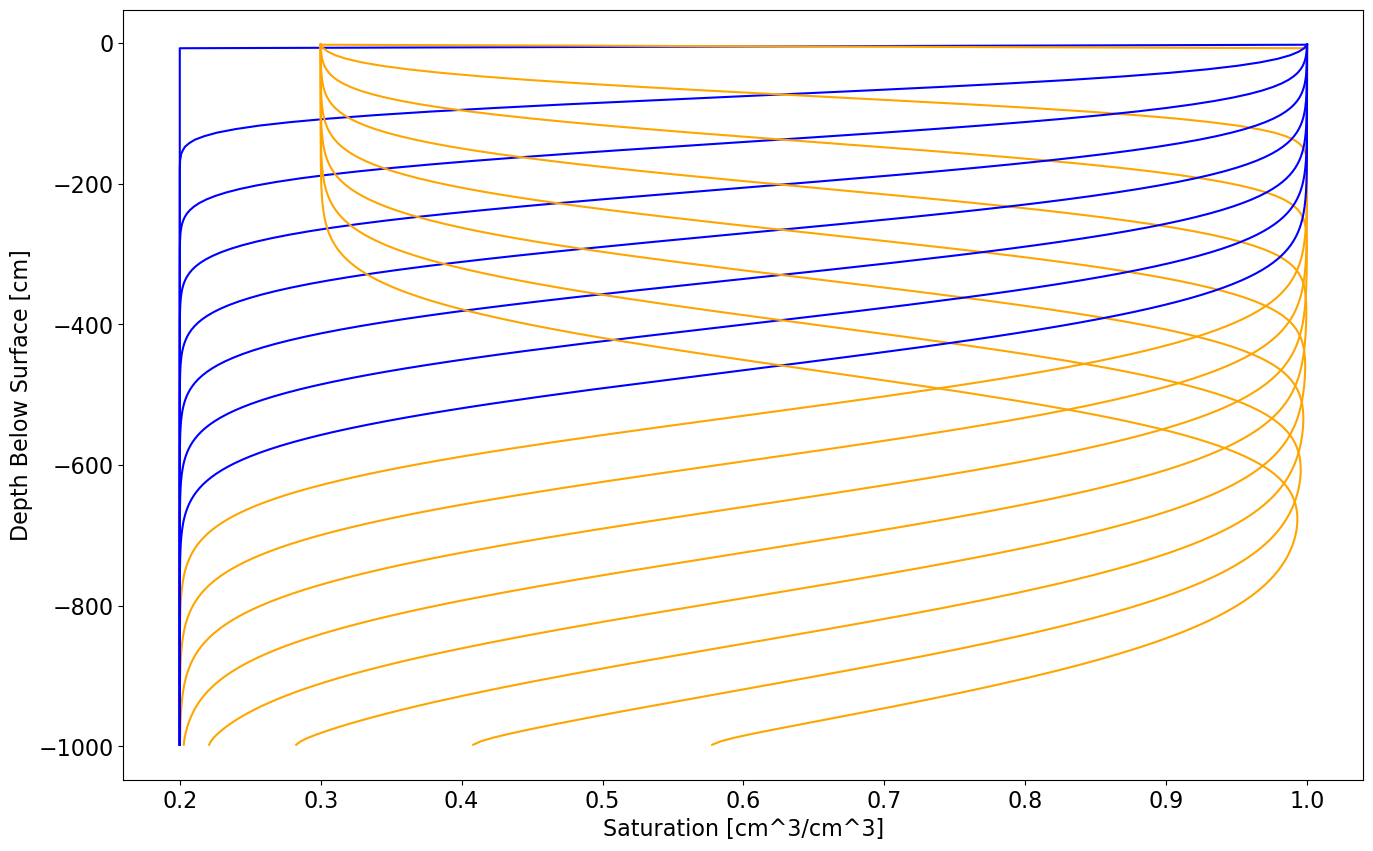

In [13]:
plt.rcParams.update({'font.size': 16}) # Change font size to something legible
plt.figure(figsize=(16,10)) # Create a figure

for p in np.arange(0,Nt_index,50): # Loop through and plot every 50th simulated soil moisture profile as a blue line 
    plt.plot(theta[:,p],-z,'b',label = '0-2000 hours') 
    # Note sign of z... we're now plotting z as negative into the soil surface
    
    plt.plot(theta[:,Nt_index+p],-z,'orange',label = '2,000 - 4000 hours')
    
# Add labels with units
plt.xlabel('Saturation [cm^3/cm^3]')
plt.ylabel('Depth Below Surface [cm]')
plt.show()

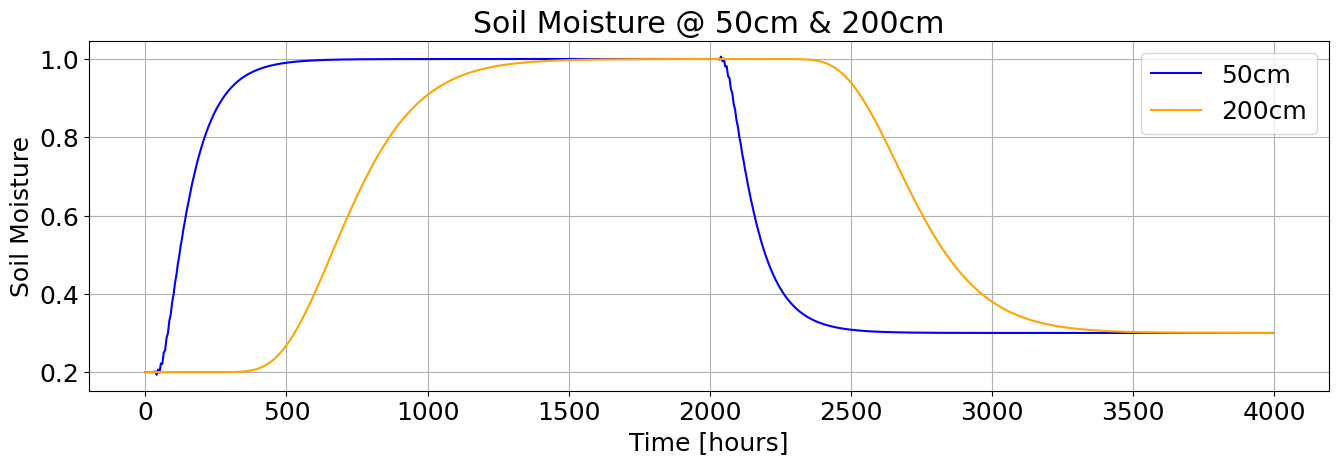

In [14]:
# plot soil moisture for 50cm and 200cm 

z50 = (np.absolute(z-50.0)).argmin() # index @ 50cm
z200 = (np.absolute(z-200.0)).argmin() # index @ 200cm

plt.rcParams.update({'font.size': 18}) # Change font size to something legible
plt.figure(figsize=(16,10)) # Create a figure

plt.subplot(2,1,1)
plt.plot(t,theta[z50,:],'b-',label='50cm')
plt.plot(t,theta[z200,:],'orange',label='200cm')
plt.ylabel('Soil Moisture')
plt.xlabel('Time [hours]')
plt.title('Soil Moisture @ 50cm & 200cm')
plt.legend()
plt.grid()
plt.show()

# Questions

1. We know that framing the evolution of soil moisture as an advection-dispersion problem required a number of questionable assumptions. If a full Richards solving model is our best approximation of the underlying process, how might we assess under what conditions our model is a reasonable approximation? Specifically, describe a set of numerical experiments.

2. In class we considered the case where we were using a flux boundary condition and the input flux rate was taken to be the minimum of the precipitation rate and saturated hydraulic conductivity of the soil. Under conditions where precipitation exceeds the saturated hydraulic conductivity, how might you model where the excess precipitation (precipitation minus saturated hydraulic conductivity) goes?